In [ ]:
# Notebook for testing unsupervised learning on the signals from 3 people

In [1]:
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from core_functions import load_data
import numpy as np

Xraw, yraw = load_data("./second_collection_triggs_rels.npz")

print("Raw data shape: ", Xraw.shape)
print("Labels shape: ", yraw.shape)
print("Unique labels: ", np.unique(yraw))

Xtrain, Xtest, ytrain, ytest = train_test_split(Xraw, yraw, test_size=0.15, random_state=42)
print("Size of test set:", Xtest.shape)
print("Size of train set:", Xtrain.shape)
print("Fraction of single class in test set: ", np.mean(ytest==0))

def normalize(x):   
    return x / np.max(x, axis=1)[:, np.newaxis]

Xtrain = normalize(Xtrain) 
Xtest = normalize(Xtest)
print("\nTrain and Test set were normalized!")

Raw data shape:  (7931, 30)
Labels shape:  (7931,)
Unique labels:  [0 1 2]
Size of test set: (1190, 30)
Size of train set: (6741, 30)
Fraction of single class in test set:  0.3033613445378151

Train and Test set were normalized!


Fraction of variance in each component: [0.7602342  0.10846632]
Total explained variance: 0.8687005223865946


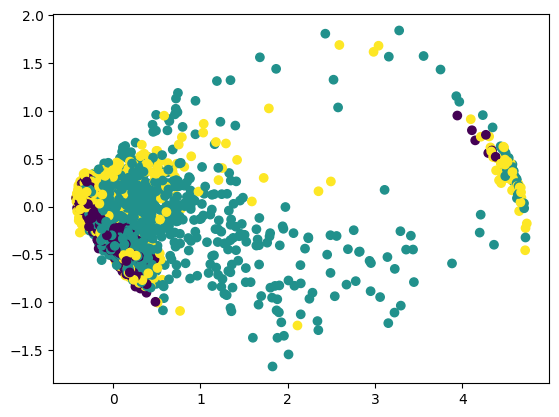

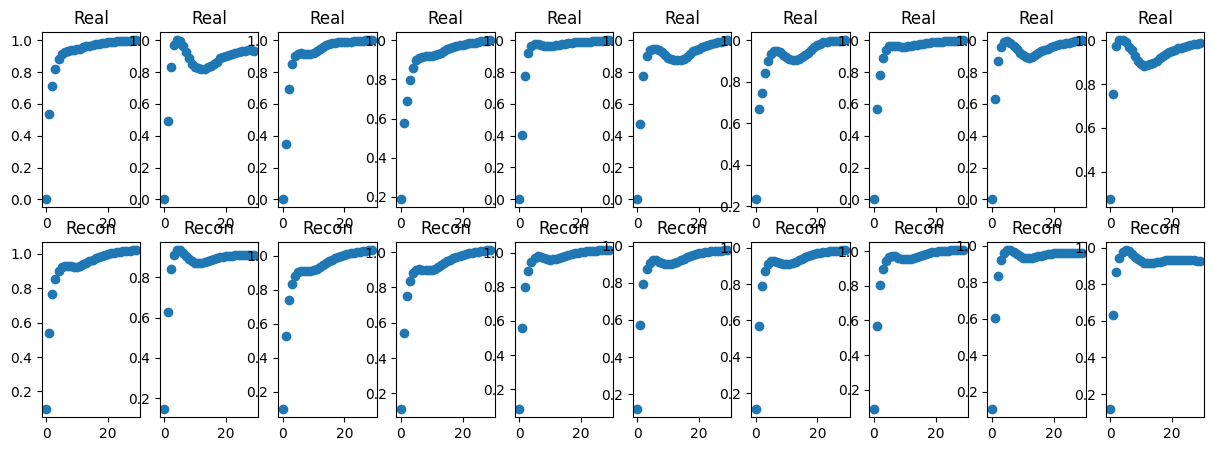

Fraction of variance in each component: [0.7602342  0.10846632 0.05899959]
Total explained variance: 0.9277001091992038


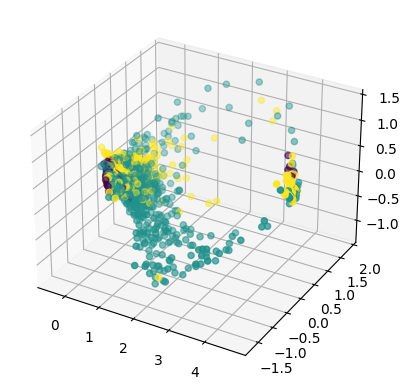

In [3]:
# Now do PCA
def pca_transform(N):
    pca = PCA(n_components=N)
    pca.fit(Xtrain)
    trans = pca.transform(Xtrain)
    recon = pca.inverse_transform(trans)
    print("Fraction of variance in each component:", pca.explained_variance_ratio_)
    print("Total explained variance:", pca.explained_variance_ratio_.sum() )
    return trans, recon

trans, recon = pca_transform(2)
plt.scatter(trans[:, 0], trans[:, 1], c=ytrain)
plt.show()

plt.figure(figsize=(15, 5))
for i in range(10):
    plt.subplot(2, 10, i+1)
    plt.scatter(range(Xtrain[i].size), Xtrain[i])
    plt.title("Real")

    plt.subplot(2, 10, i+11)
    plt.scatter(range(recon[i].size), recon[i])
    plt.title("Recon")
plt.show()

from mpl_toolkits.mplot3d import Axes3D
trans, recon = pca_transform(3)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(trans[:,0], trans[:,1], trans[:,2], c=ytrain)
plt.show()



In [44]:
# Auto Encoder
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets
from torchvision import transforms as T

USE_GPU = True
dtype = torch.float32 # Best type for cuda

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
print('using device:', device)

#Build a trainset
trainset = []
for i, (x, y) in enumerate(zip(Xtrain, ytrain)):
    trainset.append([np.array(x)[np.newaxis, :], y])

using device: cpu


In [45]:
# Convolutional Encoder
class Flatten(nn.Module):
    def forward(self, x):
        return x.view(x.shape[0], -1)

class Reshape(nn.Module):
    def forward(self, x):
        return x.view(x.shape[0], 128, 2)
    
class AutoEnc2D(nn.Module):
    def __init__(self):
        super(AutoEnc2D, self).__init__()
        self.encoder = nn.Sequential(
            # 1 input image channel, 16 output channel, 3x3 square convolution
            nn.Conv1d(1, 16, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv1d(16, 32, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv1d(32, 64, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv1d(64, 128, 3, stride=2, padding=1),
            nn.ReLU(),
            Flatten(),
            nn.Linear(128 * 2, 2)
        )
        self.decoder = nn.Sequential(
            nn.Linear(2, 128 * 2),
            Reshape(),
            nn.ReLU(),
            nn.ConvTranspose1d(128, 64, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose1d(64, 32, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose1d(32, 16, 3, stride=2, padding=1, output_padding=0),
            nn.ReLU(),
            nn.ConvTranspose1d(16, 1, 3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()  #to range [0, 1]
        )
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

# Weight initialization to ease training procedure
def weight_init(m): 
    """
    Method to insure that weights of each layer are initialized always to 
    the same values for reproducibiity
    """
    if isinstance(m, nn.Linear) or isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        torch.manual_seed(180200742)
        nn.init.kaiming_normal_(m.weight)     # Read somewhere that Kaiming initialization is advisable
        nn.init.zeros_(m.bias)

In [46]:
from torch.utils.data import DataLoader

def train_AE(model, dataset, batch_size=32, learning_rate=1e-3, max_epochs=20):

    #Choose mean square error loss
    criterion = nn.MSELoss() 

    #Choose the Adam optimiser
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)

    #Specify how the data will be loaded in batches (with random shuffling)
    train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    #Storage
    outputs = []

    model.to(device)
    model.apply(weight_init)
    
    #Start training
    for epoch in range(max_epochs):
        for i, (sig_batch, y_batch) in enumerate(train_loader):

            sig_batch = sig_batch.to(device, dtype=dtype)

            recon = model(sig_batch)
            loss = criterion(recon, sig_batch)
            loss.backward()
            optimizer.step()  
            optimizer.zero_grad()
          
            if ((i % 100) == 0):
                print(f"Epoch {epoch}, iter={i}, loss={loss.item():.4f}")
            outputs.append(loss.item())

    return outputs

AE = AutoEnc2D()

outputs = train_AE(AE, trainset)
print("Train finished!")

Epoch 0, iter=0, loss=0.1270
Epoch 0, iter=100, loss=0.0048
Epoch 0, iter=200, loss=0.0065
Epoch 1, iter=0, loss=0.0030
Epoch 1, iter=100, loss=0.0021
Epoch 1, iter=200, loss=0.0026
Epoch 2, iter=0, loss=0.0028
Epoch 2, iter=100, loss=0.0019
Epoch 2, iter=200, loss=0.0022
Epoch 3, iter=0, loss=0.0018
Epoch 3, iter=100, loss=0.0028
Epoch 3, iter=200, loss=0.0021
Epoch 4, iter=0, loss=0.0012
Epoch 4, iter=100, loss=0.0014
Epoch 4, iter=200, loss=0.0012
Epoch 5, iter=0, loss=0.0010
Epoch 5, iter=100, loss=0.0015
Epoch 5, iter=200, loss=0.0022
Epoch 6, iter=0, loss=0.0011
Epoch 6, iter=100, loss=0.0014
Epoch 6, iter=200, loss=0.0020
Epoch 7, iter=0, loss=0.0033
Epoch 7, iter=100, loss=0.0019
Epoch 7, iter=200, loss=0.0023
Epoch 8, iter=0, loss=0.0009
Epoch 8, iter=100, loss=0.0009
Epoch 8, iter=200, loss=0.0012
Epoch 9, iter=0, loss=0.0011
Epoch 9, iter=100, loss=0.0014
Epoch 9, iter=200, loss=0.0020
Epoch 10, iter=0, loss=0.0021
Epoch 10, iter=100, loss=0.0010
Epoch 10, iter=200, loss=0.0

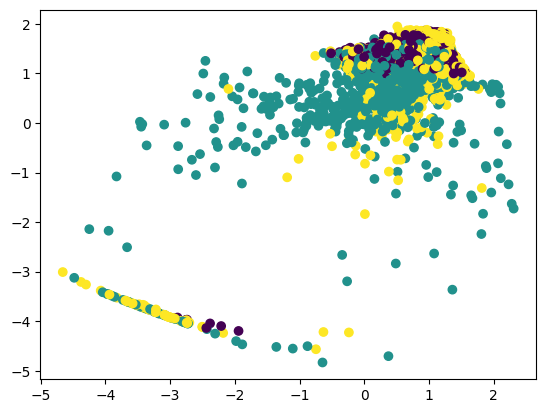

<AxesSubplot: >

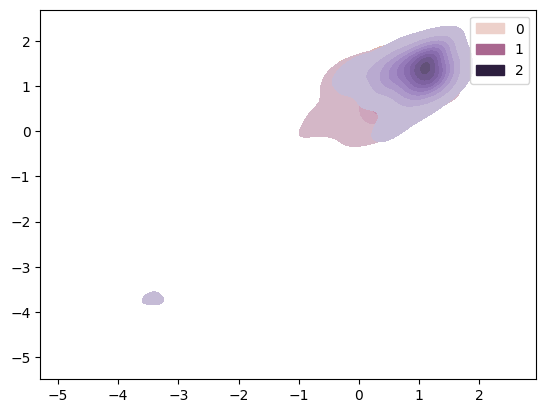

In [50]:
# Look at encoded results
x = torch.tensor(Xtrain[:, np.newaxis, :], dtype=dtype)
with torch.no_grad():
    enc = AE.encoder(x).detach().numpy()
    plt.scatter(enc[:, 0], enc[:, 1], c=ytrain)
    plt.show()

import seaborn as sns
sns.kdeplot(x=enc[:,0], y=enc[:, 1], hue=ytrain, fill=True)

In [53]:
# K-Means clustering
from sklearn.cluster import k_means
km_centroids, km_clusters, inertia = k_means(Xtrain, n_clusters=3)

def calcPurity(true_labels, clusters):
    purities = []
    cluster_sizes = []
    for i in range(len(np.unique(clusters))):
        pred_labels = true_labels[clusters==i]
        _, counts = np.unique(pred_labels, return_counts=True)
        p = np.max(counts) / len(pred_labels)
        print(f"Purity of cluster {i}: {p}, size {len(pred_labels)} ")
        purities.append(p)
        cluster_sizes.append(len(pred_labels))
    
    mean_p = np.multiply(cluster_sizes, purities).sum()/len(true_labels)
    print("\nMean purity: ", mean_p)
    return mean_p
    
calcPurity(ytrain, km_clusters)

Purity of cluster 0: 0.3678861788617886, size 6396 
Purity of cluster 1: 0.484375, size 128 
Purity of cluster 2: 0.9078341013824884, size 217 

Mean purity:  0.38747960243287344


0.38747960243287344

In [59]:
# Spectral clustering
from scipy.spatial.distance import cdist
from sklearn.cluster import spectral_clustering 

sigma = 0.2
W = np.exp(-0.5*cdist(Xtrain, Xtrain, 'sqeuclidean')/sigma**2)
# Apply spectral clustering on the precalculated similarity matrix W
sc_clusters = spectral_clustering(W, n_clusters=3)

calcPurity(ytrain, sc_clusters)

Purity of cluster 0: 0.387106357694593, size 6732 
Purity of cluster 1: 0.5, size 6 
Purity of cluster 2: 1.0, size 3 

Mean purity:  0.38747960243287344


0.38747960243287344

In [ ]:
# Main conclusion from this script is that both PCA and Autoencoders 
# performing a reduction of dimensions to 2 dimensions are not enough 
# to accurately distinguish between two people, as there is a strong 
# overlap of points in the scatter plots. 2 dimensions capture about 
# 80% of the variance, so it is not likely that highly distinct
# groups appear for higher dimensions. Doing PCA for 3 dimensions did
# not help separating the gropus, so I am inferring that exploring further 
# dimensions will not yield much better results.

# Both k-means clustering and spectral clustering did not give good results,
# mostly because points severely overlap.

# Therefore I will not explore these avenues further.